In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from time import perf_counter
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff

from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

seeds = 1002034

# Set seeds to make the experiment more reproducible.
import tensorflow as tf
from tensorflow.compat.v1.profiler import Profiler
from tensorflow.compat.v1 import set_random_seed
set_random_seed(seeds)
from numpy.random import seed
seed(seeds)
from tensorflow.random import set_seed
set_seed(seeds)

2023-05-06 05:31:13.836850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Loading data

In [3]:
train = pd.read_csv('/workspace/PlayNet/handball_X_train.csv')
train = reduce_mem_usage(train)
train["#play"] = pd.read_csv('/workspace/PlayNet/handball_y_train.csv')["#play"]

test = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')
test = reduce_mem_usage(test)
test["#play"] = pd.read_csv('/workspace/PlayNet/handball_y_test.csv')["#play"]

Memory usage of dataframe is 353.68 MB
Memory usage after optimization is: 88.42 MB
Decreased by 75.0%
Memory usage of dataframe is 151.58 MB
Memory usage after optimization is: 37.89 MB
Decreased by 75.0%


### Train set

In [4]:
train.describe()

#x0            #y0           #vx0           #vy0  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN       0.000000      -0.000000   
std         0.000000       0.000000       0.000000       0.000000   
min         0.000000       0.000000      -0.999023      -0.999512   
25%         0.265381       0.256104      -0.222168      -0.194458   
50%         0.500488       0.477539       0.003165       0.000294   
75%         0.729492       0.698242       0.223511       0.188843   
max         1.000000       1.000000       0.999512       1.000000   

                 #x1            #y1           #vx1           #vy1  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN       0.000000      -0.000000   
std         0.000000       0.000000       0.000000       0.000000   
min         0.000000       0.000000      -0.985840      -0.899414   
25%         0.254395       0.242432      -0.158203      -0.133667   
50%         0.500488       0.473877       0.005096       0.000806   
75%         0.737305       0.704590       0.164551       0.132935   
max         1.000000       1.000000       0.995605       0.921387   

                 #x2            #y2  ...      #x14      #y14          #vx14  \
count  702382.000000  702382.000000  ...  702382.0  702382.0  702382.000000   
mean             NaN            NaN  ...       0.0       0.0      -0.000000   
std         0.000000       0.000000  ...       0.0       0.0       0.000000   
min         0.000000       0.000000  ...       0.0       0.0      -0.459229   
25%         0.238037       0.234497  ...       0.0       0.0       0.000000   
50%         0.496094       0.473633  ...       0.0       0.0       0.000000   
75%         0.751465       0.709473  ...       0.0       0.0       0.000000   
max         1.000000       1.000000  ...       1.0       1.0       0.466309   

               #vy14      #x15      #y15          #vx15          #vy15  \
count  702382.000000  702382.0  702382.0  702382.000000  702382.000000   
mean       -0.000000       0.0       0.0      -0.000000      -0.000000   
std         0.000000       0.0       0.0       0.000000       0.000000   
min        -0.406494       0.0       0.0      -0.414062      -0.330322   
25%         0.000000       0.0       0.0       0.000000       0.000000   
50%         0.000000       0.0       0.0       0.000000       0.000000   
75%         0.000000       0.0       0.0       0.000000       0.000000   
max         0.463623       1.0       1.0       0.451416       0.347900   

        #ball_x   #ball_y  
count  702382.0  702382.0  
mean        0.0       0.0  
std         0.0       0.0  
min         0.0       0.0  
25%         0.0       0.0  
50%         0.0       0.0  
75%         0.0       0.0  
max         1.0       1.0  

[8 rows x 66 columns]

In [5]:
train.head()

#x0       #y0      #vx0      #vy0       #x1       #y1      #vx1  \
0  0.437256  0.920410  0.000000  0.000000  0.302246  0.002157  0.000000   
1  0.523438  0.031525 -0.050354 -0.233887  0.437744  0.920898  0.039246   
2  0.523438  0.026306 -0.024063 -0.293701  0.438232  0.920898  0.050812   
3  0.523438  0.022705 -0.012863 -0.276611  0.438232  0.921875  0.033630   
4  0.523438  0.019302 -0.012039 -0.263428  0.438232  0.923340  0.026688   

       #vy1       #x2       #y2  ...  #y14  #vx14  #vy14  #x15  #y15  #vx15  \
0  0.000000  0.523926  0.036316  ...   0.0    0.0    0.0   0.0   0.0    0.0   
1  0.003649  0.302490  0.001530  ...   0.0    0.0    0.0   0.0   0.0    0.0   
2  0.013390  0.000000  0.000000  ...   0.0    0.0    0.0   0.0   0.0    0.0   
3  0.033356  0.000000  0.000000  ...   0.0    0.0    0.0   0.0   0.0    0.0   
4  0.045807  0.723633  0.086914  ...   0.0    0.0    0.0   0.0   0.0    0.0   

   #vy15  #ball_x  #ball_y     #play  
0    0.0      0.0      0.0  time_out  
1    0.0      0.0      0.0  time_out  
2    0.0      0.0      0.0  time_out  
3    0.0      0.0      0.0  time_out  
4    0.0      0.0      0.0  time_out  

[5 rows x 67 columns]

In [6]:
def one_hot_encode(df, labelencoder, enc):
    # Assigning numerical values and storing in another column
    df['#play'] = labelencoder.fit_transform(df['#play'])

    df['#play'].value_counts()

    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = pd.DataFrame(enc.fit_transform(df[['#play']]).toarray())

    # merge with main df bridge_df on key values
    df = df.join(enc_df)

    df = df.drop(columns=['#play'])
    
    return df

In [7]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

train = one_hot_encode(train, labelencoder, enc)
test = one_hot_encode(test, labelencoder, enc)

train.describe()

#x0            #y0           #vx0           #vy0  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN       0.000000      -0.000000   
std         0.000000       0.000000       0.000000       0.000000   
min         0.000000       0.000000      -0.999023      -0.999512   
25%         0.265381       0.256104      -0.222168      -0.194458   
50%         0.500488       0.477539       0.003165       0.000294   
75%         0.729492       0.698242       0.223511       0.188843   
max         1.000000       1.000000       0.999512       1.000000   

                 #x1            #y1           #vx1           #vy1  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN       0.000000      -0.000000   
std         0.000000       0.000000       0.000000       0.000000   
min         0.000000       0.000000      -0.985840      -0.899414   
25%         0.254395       0.242432      -0.158203      -0.133667   
50%         0.500488       0.473877       0.005096       0.000806   
75%         0.737305       0.704590       0.164551       0.132935   
max         1.000000       1.000000       0.995605       0.921387   

                 #x2            #y2  ...          #vy15   #ball_x   #ball_y  \
count  702382.000000  702382.000000  ...  702382.000000  702382.0  702382.0   
mean             NaN            NaN  ...      -0.000000       0.0       0.0   
std         0.000000       0.000000  ...       0.000000       0.0       0.0   
min         0.000000       0.000000  ...      -0.330322       0.0       0.0   
25%         0.238037       0.234497  ...       0.000000       0.0       0.0   
50%         0.496094       0.473633  ...       0.000000       0.0       0.0   
75%         0.751465       0.709473  ...       0.000000       0.0       0.0   
max         1.000000       1.000000  ...       0.347900       1.0       1.0   

                   0              1              2              3  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean        0.377689       0.005675       0.093230       0.371499   
std         0.484810       0.075118       0.290755       0.483206   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

                   4              5              6  
count  702382.000000  702382.000000  702382.000000  
mean        0.008515       0.099063       0.044329  
std         0.091885       0.298747       0.205826  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000  

[8 rows x 73 columns]

In [8]:
train.head()

#x0       #y0      #vx0      #vy0       #x1       #y1      #vx1  \
0  0.437256  0.920410  0.000000  0.000000  0.302246  0.002157  0.000000   
1  0.523438  0.031525 -0.050354 -0.233887  0.437744  0.920898  0.039246   
2  0.523438  0.026306 -0.024063 -0.293701  0.438232  0.920898  0.050812   
3  0.523438  0.022705 -0.012863 -0.276611  0.438232  0.921875  0.033630   
4  0.523438  0.019302 -0.012039 -0.263428  0.438232  0.923340  0.026688   

       #vy1       #x2       #y2  ...  #vy15  #ball_x  #ball_y    0    1    2  \
0  0.000000  0.523926  0.036316  ...    0.0      0.0      0.0  0.0  0.0  0.0   
1  0.003649  0.302490  0.001530  ...    0.0      0.0      0.0  0.0  0.0  0.0   
2  0.013390  0.000000  0.000000  ...    0.0      0.0      0.0  0.0  0.0  0.0   
3  0.033356  0.000000  0.000000  ...    0.0      0.0      0.0  0.0  0.0  0.0   
4  0.045807  0.723633  0.086914  ...    0.0      0.0      0.0  0.0  0.0  0.0   

     3    4    5    6  
0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  1.0  

[5 rows x 73 columns]

### Transform the data into a time series problem

In [9]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [10]:
window = 7
lag = 0
#series = series_to_supervised(train.drop(columns=[0,1,2,3,4,5,6]), window=window, lag=lag)
series = series_to_supervised(train, window=window, lag=lag)
series_test = series_to_supervised(test, window=window, lag=lag)
pd.set_option('display.max_columns', None)
series.head()

#x0(t-7)  #y0(t-7)  #vx0(t-7)  #vy0(t-7)  #x1(t-7)  #y1(t-7)  #vx1(t-7)  \
7   0.437256  0.920410   0.000000   0.000000  0.302246  0.002157   0.000000   
8   0.523438  0.031525  -0.050354  -0.233887  0.437744  0.920898   0.039246   
9   0.523438  0.026306  -0.024063  -0.293701  0.438232  0.920898   0.050812   
10  0.523438  0.022705  -0.012863  -0.276611  0.438232  0.921875   0.033630   
11  0.523438  0.019302  -0.012039  -0.263428  0.438232  0.923340   0.026688   

    #vy1(t-7)  #x2(t-7)  #y2(t-7)  #vx2(t-7)  #vy2(t-7)  #x3(t-7)  #y3(t-7)  \
7    0.000000  0.523926  0.036316   0.000000   0.000000       0.0       0.0   
8    0.003649  0.302490  0.001530   0.016281  -0.030655       0.0       0.0   
9    0.013390  0.000000  0.000000   0.000000   0.000000       0.0       0.0   
10   0.033356  0.000000  0.000000   0.000000   0.000000       0.0       0.0   
11   0.045807  0.723633  0.086914   0.000000   0.000000       0.0       0.0   

    #vx3(t-7)  #vy3(t-7)  #x4(t-7)  #y4(t-7)  #vx4(t-7)  #vy4(t-7)  #x5(t-7)  \
7         0.0        0.0       0.0       0.0        0.0        0.0       0.0   
8         0.0        0.0       0.0       0.0        0.0        0.0       0.0   
9         0.0        0.0       0.0       0.0        0.0        0.0       0.0   
10        0.0        0.0       0.0       0.0        0.0        0.0       0.0   
11        0.0        0.0       0.0       0.0        0.0        0.0       0.0   

    #y5(t-7)  #vx5(t-7)  #vy5(t-7)  #x6(t-7)  #y6(t-7)  #vx6(t-7)  #vy6(t-7)  \
7        0.0        0.0        0.0       0.0       0.0        0.0        0.0   
8        0.0        0.0        0.0       0.0       0.0        0.0        0.0   
9        0.0        0.0        0.0       0.0       0.0        0.0        0.0   
10       0.0        0.0        0.0       0.0       0.0        0.0        0.0   
11       0.0        0.0        0.0       0.0       0.0        0.0        0.0   

    #x7(t-7)  #y7(t-7)  #vx7(t-7)  #vy7(t-7)  #x8(t-7)  #y8(t-7)  #vx8(t-7)  \
7        0.0       0.0        0.0        0.0       0.0       0.0        0.0   
8        0.0       0.0        0.0        0.0       0.0       0.0        0.0   
9        0.0       0.0        0.0        0.0       0.0       0.0        0.0   
10       0.0       0.0        0.0        0.0       0.0       0.0        0.0   
11       0.0       0.0        0.0        0.0       0.0       0.0        0.0   

    #vy8(t-7)  #x9(t-7)  #y9(t-7)  #vx9(t-7)  #vy9(t-7)  #x10(t-7)  #y10(t-7)  \
7         0.0       0.0       0.0        0.0        0.0        0.0        0.0   
8         0.0       0.0       0.0        0.0        0.0        0.0        0.0   
9         0.0       0.0       0.0        0.0        0.0        0.0        0.0   
10        0.0       0.0       0.0        0.0        0.0        0.0        0.0   
11        0.0       0.0       0.0        0.0        0.0        0.0        0.0   

    #vx10(t-7)  #vy10(t-7)  #x11(t-7)  #y11(t-7)  #vx11(t-7)  #vy11(t-7)  \
7          0.0         0.0        0.0        0.0         0.0         0.0   
8          0.0         0.0        0.0        0.0         0.0         0.0   
9          0.0         0.0        0.0        0.0         0.0         0.0   
10         0.0         0.0        0.0        0.0         0.0         0.0   
11         0.0         0.0        0.0        0.0         0.0         0.0   

    #x12(t-7)  #y12(t-7)  #vx12(t-7)  #vy12(t-7)  #x13(t-7)  #y13(t-7)  \
7         0.0        0.0         0.0         0.0        0.0        0.0   
8         0.0        0.0         0.0         0.0        0.0        0.0   
9         0.0        0.0         0.0         0.0        0.0        0.0   
10        0.0        0.0         0.0         0.0        0.0        0.0   
11        0.0        0.0         0.0         0.0        0.0        0.0   

    #vx13(t-7)  #vy13(t-7)  #x14(t-7)  #y14(t-7)  #vx14(t-7)  #vy14(t-7)  \
7          0.0         0.0        0.0        0.0         0.0         0.0   
8          0.0         0.0        0.0        0.0         0.0         0.0   


In [11]:
train.head()

#x0       #y0      #vx0      #vy0       #x1       #y1      #vx1  \
0  0.437256  0.920410  0.000000  0.000000  0.302246  0.002157  0.000000   
1  0.523438  0.031525 -0.050354 -0.233887  0.437744  0.920898  0.039246   
2  0.523438  0.026306 -0.024063 -0.293701  0.438232  0.920898  0.050812   
3  0.523438  0.022705 -0.012863 -0.276611  0.438232  0.921875  0.033630   
4  0.523438  0.019302 -0.012039 -0.263428  0.438232  0.923340  0.026688   

       #vy1       #x2       #y2      #vx2      #vy2  #x3  #y3  #vx3  #vy3  \
0  0.000000  0.523926  0.036316  0.000000  0.000000  0.0  0.0   0.0   0.0   
1  0.003649  0.302490  0.001530  0.016281 -0.030655  0.0  0.0   0.0   0.0   
2  0.013390  0.000000  0.000000  0.000000  0.000000  0.0  0.0   0.0   0.0   
3  0.033356  0.000000  0.000000  0.000000  0.000000  0.0  0.0   0.0   0.0   
4  0.045807  0.723633  0.086914  0.000000  0.000000  0.0  0.0   0.0   0.0   

   #x4  #y4  #vx4  #vy4  #x5  #y5  #vx5  #vy5  #x6  #y6  #vx6  #vy6  #x7  #y7  \
0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   
1  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   
2  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   
3  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   
4  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   

   #vx7  #vy7  #x8  #y8  #vx8  #vy8  #x9  #y9  #vx9  #vy9  #x10  #y10  #vx10  \
0   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0    0.0   
1   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0    0.0   
2   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0    0.0   
3   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0    0.0   
4   0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0    0.0   

   #vy10  #x11  #y11  #vx11  #vy11  #x12  #y12  #vx12  #vy12  #x13  #y13  \
0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
1    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
2    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
3    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   
4    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0   

   #vx13  #vy13  #x14  #y14  #vx14  #vy14  #x15  #y15  #vx15  #vy15  #ball_x  \
0    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0      0.0   
1    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0      0.0   
2    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0      0.0   
3    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0      0.0   
4    0.0    0.0   0.0   0.0    0.0    0.0   0.0   0.0    0.0    0.0      0.0   

   #ball_y    0    1    2    3    4    5    6  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

#### Remove unwanted columns

In [12]:
columns = list(train.columns)
pred_columns = [0,1,2,3,4,5,6]
data_columns = [item for item in columns if item not in pred_columns]

columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in columns]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in pred_columns]

series.drop(columns_to_drop, axis=1, inplace=True)
series_test.drop(columns_to_drop, axis=1, inplace=True)

series_test.head()

#x0(t-7)  #y0(t-7)  #vx0(t-7)  #vy0(t-7)  #x1(t-7)  #y1(t-7)  #vx1(t-7)  \
7   0.312256  0.559082   0.098816   0.090210  0.405273  0.604004   0.084351   
8   0.313232  0.560547   0.106567   0.097900  0.405273  0.604980   0.068970   
9   0.314209  0.562012   0.109436   0.100769  0.405762  0.606934   0.080994   
10  0.315186  0.563477   0.110840   0.102234  0.406006  0.607910   0.062744   
11  0.315918  0.564453   0.112305   0.103760  0.406250  0.609375   0.065491   

    #vy1(t-7)  #x2(t-7)  #y2(t-7)  #vx2(t-7)  #vy2(t-7)  #x3(t-7)  #y3(t-7)  \
7    0.089966  0.327148  0.862793   0.059296   0.085083  0.372314  0.871094   
8    0.074402  0.327393  0.863770   0.057343   0.082275  0.372314  0.871582   
9    0.086304  0.327881  0.865234   0.055420   0.079529  0.308594  0.901367   
10   0.067871  0.308350  0.902832  -0.050842   0.076599  0.372314  0.872559   
11   0.070496  0.244751  0.971191  -0.092529  -0.020462  0.307861  0.903320   

    #vx3(t-7)  #vy3(t-7)  #x4(t-7)  #y4(t-7)  #vx4(t-7)  #vy4(t-7)  #x5(t-7)  \
7   -0.047028   0.075623  0.309570  0.899414  -0.048309   0.040436  0.247559   
8   -0.047119   0.069885  0.246826  0.971191  -0.068420   0.008057  0.309082   
9   -0.052063   0.074097  0.372314  0.872070  -0.038544   0.072937  0.246338   
10  -0.036499   0.069519  0.840332  0.478516  -0.050507  -0.046326  0.285400   
11  -0.052460   0.056854  0.372314  0.872559  -0.038239   0.062622  0.839844   

    #y5(t-7)  #vx5(t-7)  #vy5(t-7)  #x6(t-7)  #y6(t-7)  #vx6(t-7)  #vy6(t-7)  \
7   0.971191  -0.054840   0.023605  0.125122  0.241211   0.036621   0.040314   
8   0.899414  -0.061218   0.023727  0.284424  0.088684   0.037537   0.039825   
9   0.971191  -0.063843   0.010994  0.284912  0.089539   0.042114   0.044342   
10  0.090515   0.046234   0.048401  0.245728  0.971680  -0.064026   0.009331   
11  0.477783  -0.053284  -0.049225  0.285645  0.091370   0.048096   0.050171   

    #x7(t-7)  #y7(t-7)  #vx7(t-7)  #vy7(t-7)  #x8(t-7)  #y8(t-7)  #vx8(t-7)  \
7   0.284180  0.088013   0.036194   0.038574  0.841797  0.480713  -0.031616   
8   0.125488  0.241455   0.036285   0.039825  0.841309  0.480225  -0.034393   
9   0.840820  0.479492  -0.042694  -0.038361  0.125732  0.241821   0.035126   
10  0.125854  0.241943   0.032196   0.035461  0.148315  0.727539  -0.006008   
11  0.125977  0.241943   0.026230   0.029358  0.148315  0.728027  -0.004276   

    #vy8(t-7)  #x9(t-7)  #y9(t-7)  #vx9(t-7)  #vy9(t-7)  #x10(t-7)  #y10(t-7)  \
7   -0.026993  0.181885  0.368652   0.028656   0.028809   0.148560   0.726074   
8   -0.029907  0.181885  0.368896   0.022964   0.023117   0.148438   0.726074   
9    0.038513  0.152466  0.899902  -0.019470  -0.021408   0.158081   0.606934   
10   0.029892  0.152344  0.899414  -0.020355  -0.022232   0.157959   0.606934   
11   0.031677  0.152344  0.898926  -0.014664  -0.016479   0.157837   0.607422   

    #vx10(t-7)  #vy10(t-7)  #x11(t-7)  #y11(t-7)  #vx11(t-7)  #vy11(t-7)  \
7    -0.012894    0.025070   0.158691   0.606934   -0.019760   -0.000073   
8    -0.015671    0.020950   0.158325   0.606934   -0.024979   -0.005871   
9    -0.026901   -0.008362   0.148315   0.726562   -0.012840    0.023026   
10   -0.022720   -0.004723   0.181763   0.369141    0.007355    0.007492   
11   -0.016891    0.000571   0.181519   0.368896    0.000805    0.000940   

    #x12(t-7)  #y12(t-7)  #vx12(t-7)  #vy12(t-7)  #x13(t-7)  #y13(t-7)  \
7    0.152832   0.900391   -0.008598   -0.010651        0.0        0.0   
8    0.152710   0.900391   -0.011276   -0.013275        0.0        0.0   
9    0.181885   0.369141    0.016754    0.016907        0.0        0.0   
10   0.000000   0.000000    0.000000    0.000000        0.0        0.0   
11   0.000000   0.000000    0.000000    0.000000        0.0        0.0   

    #vx13(t-7)  #vy13(t-7)  #x14(t-7)  #y14(t-7)  #vx14(t-7)  #vy14(t-7)  \
7          0.0         0.0        0.0        0.0         0.0         0.0   
8          0.0         0.0        0.0        0.0         0.0         0.0   


### Train/validation split

In [13]:
# Label
labels_col = [('%s(t)' % (col)) for col in pred_columns]
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

labels_test = series_test[labels_col]
series_test = series_test.drop(labels_col, axis=1)
X_test = series_test
Y_test = labels_test.values
X_test.head()

Train set shape (421425, 528)
Validation set shape (280950, 528)


#x0(t-7)  #y0(t-7)  #vx0(t-7)  #vy0(t-7)  #x1(t-7)  #y1(t-7)  #vx1(t-7)  \
7   0.312256  0.559082   0.098816   0.090210  0.405273  0.604004   0.084351   
8   0.313232  0.560547   0.106567   0.097900  0.405273  0.604980   0.068970   
9   0.314209  0.562012   0.109436   0.100769  0.405762  0.606934   0.080994   
10  0.315186  0.563477   0.110840   0.102234  0.406006  0.607910   0.062744   
11  0.315918  0.564453   0.112305   0.103760  0.406250  0.609375   0.065491   

    #vy1(t-7)  #x2(t-7)  #y2(t-7)  #vx2(t-7)  #vy2(t-7)  #x3(t-7)  #y3(t-7)  \
7    0.089966  0.327148  0.862793   0.059296   0.085083  0.372314  0.871094   
8    0.074402  0.327393  0.863770   0.057343   0.082275  0.372314  0.871582   
9    0.086304  0.327881  0.865234   0.055420   0.079529  0.308594  0.901367   
10   0.067871  0.308350  0.902832  -0.050842   0.076599  0.372314  0.872559   
11   0.070496  0.244751  0.971191  -0.092529  -0.020462  0.307861  0.903320   

    #vx3(t-7)  #vy3(t-7)  #x4(t-7)  #y4(t-7)  #vx4(t-7)  #vy4(t-7)  #x5(t-7)  \
7   -0.047028   0.075623  0.309570  0.899414  -0.048309   0.040436  0.247559   
8   -0.047119   0.069885  0.246826  0.971191  -0.068420   0.008057  0.309082   
9   -0.052063   0.074097  0.372314  0.872070  -0.038544   0.072937  0.246338   
10  -0.036499   0.069519  0.840332  0.478516  -0.050507  -0.046326  0.285400   
11  -0.052460   0.056854  0.372314  0.872559  -0.038239   0.062622  0.839844   

    #y5(t-7)  #vx5(t-7)  #vy5(t-7)  #x6(t-7)  #y6(t-7)  #vx6(t-7)  #vy6(t-7)  \
7   0.971191  -0.054840   0.023605  0.125122  0.241211   0.036621   0.040314   
8   0.899414  -0.061218   0.023727  0.284424  0.088684   0.037537   0.039825   
9   0.971191  -0.063843   0.010994  0.284912  0.089539   0.042114   0.044342   
10  0.090515   0.046234   0.048401  0.245728  0.971680  -0.064026   0.009331   
11  0.477783  -0.053284  -0.049225  0.285645  0.091370   0.048096   0.050171   

    #x7(t-7)  #y7(t-7)  #vx7(t-7)  #vy7(t-7)  #x8(t-7)  #y8(t-7)  #vx8(t-7)  \
7   0.284180  0.088013   0.036194   0.038574  0.841797  0.480713  -0.031616   
8   0.125488  0.241455   0.036285   0.039825  0.841309  0.480225  -0.034393   
9   0.840820  0.479492  -0.042694  -0.038361  0.125732  0.241821   0.035126   
10  0.125854  0.241943   0.032196   0.035461  0.148315  0.727539  -0.006008   
11  0.125977  0.241943   0.026230   0.029358  0.148315  0.728027  -0.004276   

    #vy8(t-7)  #x9(t-7)  #y9(t-7)  #vx9(t-7)  #vy9(t-7)  #x10(t-7)  #y10(t-7)  \
7   -0.026993  0.181885  0.368652   0.028656   0.028809   0.148560   0.726074   
8   -0.029907  0.181885  0.368896   0.022964   0.023117   0.148438   0.726074   
9    0.038513  0.152466  0.899902  -0.019470  -0.021408   0.158081   0.606934   
10   0.029892  0.152344  0.899414  -0.020355  -0.022232   0.157959   0.606934   
11   0.031677  0.152344  0.898926  -0.014664  -0.016479   0.157837   0.607422   

    #vx10(t-7)  #vy10(t-7)  #x11(t-7)  #y11(t-7)  #vx11(t-7)  #vy11(t-7)  \
7    -0.012894    0.025070   0.158691   0.606934   -0.019760   -0.000073   
8    -0.015671    0.020950   0.158325   0.606934   -0.024979   -0.005871   
9    -0.026901   -0.008362   0.148315   0.726562   -0.012840    0.023026   
10   -0.022720   -0.004723   0.181763   0.369141    0.007355    0.007492   
11   -0.016891    0.000571   0.181519   0.368896    0.000805    0.000940   

    #x12(t-7)  #y12(t-7)  #vx12(t-7)  #vy12(t-7)  #x13(t-7)  #y13(t-7)  \
7    0.152832   0.900391   -0.008598   -0.010651        0.0        0.0   
8    0.152710   0.900391   -0.011276   -0.013275        0.0        0.0   
9    0.181885   0.369141    0.016754    0.016907        0.0        0.0   
10   0.000000   0.000000    0.000000    0.000000        0.0        0.0   
11   0.000000   0.000000    0.000000    0.000000        0.0        0.0   

    #vx13(t-7)  #vy13(t-7)  #x14(t-7)  #y14(t-7)  #vx14(t-7)  #vy14(t-7)  \
7          0.0         0.0        0.0        0.0         0.0         0.0   
8          0.0         0.0        0.0        0.0         0.0         0.0   


In [14]:
print(Y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


### MLP

* Input shape **[samples, timesteps]**.

In [15]:
epochs = 40
batch = 256
lr = 0.0001
callback = EarlyStopping(monitor="val_loss", patience = 10, min_delta=0.0003, restore_best_weights=True)
rms = optimizers.legacy.RMSprop(lr)

In [16]:
model_mlp = Sequential()
model_mlp.add(Dense(500, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(500, activation='relu'))
model_mlp.add(Dense(2000, activation='relu'))
model_mlp.add(Dense(len(pred_columns)))
model_mlp.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               264500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 2000)              1002000   
                                                                 
 dense_3 (Dense)             (None, 7)                 14007     
                                                                 
Total params: 1,531,007
Trainable params: 1,531,007
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2, callbacks=callback)

Epoch 1/40
13170/13170 - 68s - loss: 0.4324 - accuracy: 0.8172 - val_loss: 0.2907 - val_accuracy: 0.8612 - 68s/epoch - 5ms/step
Epoch 2/40
13170/13170 - 67s - loss: 0.2980 - accuracy: 0.8586 - val_loss: 0.2945 - val_accuracy: 0.8598 - 67s/epoch - 5ms/step
Epoch 3/40
13170/13170 - 77s - loss: 0.2916 - accuracy: 0.8598 - val_loss: 0.3018 - val_accuracy: 0.8573 - 77s/epoch - 6ms/step
Epoch 4/40
13170/13170 - 77s - loss: 0.2953 - accuracy: 0.8629 - val_loss: 0.2750 - val_accuracy: 0.8701 - 77s/epoch - 6ms/step
Epoch 5/40
13170/13170 - 68s - loss: 0.2940 - accuracy: 0.8678 - val_loss: 0.3243 - val_accuracy: 0.8672 - 68s/epoch - 5ms/step
Epoch 6/40
13170/13170 - 69s - loss: 0.2951 - accuracy: 0.8725 - val_loss: 0.2892 - val_accuracy: 0.8756 - 69s/epoch - 5ms/step
Epoch 7/40
13170/13170 - 70s - loss: 0.2988 - accuracy: 0.8800 - val_loss: 0.3283 - val_accuracy: 0.8832 - 70s/epoch - 5ms/step
Epoch 8/40
13170/13170 - 69s - loss: 0.3118 - accuracy: 0.8860 - val_loss: 0.3213 - val_accuracy: 0.8900

### CNN

* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [18]:
features = 66
timesteps = X_train.shape[1] // features
X_train_series = X_train.values.reshape((X_train.shape[0], timesteps, features))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], timesteps, features))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (421425, 8, 66)
Validation set shape (280950, 8, 66)


In [19]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=512, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model_cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=1))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='relu'))
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(len(pred_columns)))

model_cnn.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 512)            68096     
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 512)            524800    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 512)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 256)            262400    
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 256)            131328    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 256)           0         
 1D)                                                  

In [20]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2, callbacks=callback)

Epoch 1/40
13170/13170 - 143s - loss: 0.3451 - accuracy: 0.8350 - val_loss: 0.1933 - val_accuracy: 0.8928 - 143s/epoch - 11ms/step
Epoch 2/40
13170/13170 - 137s - loss: 0.2287 - accuracy: 0.8862 - val_loss: 0.2157 - val_accuracy: 0.8869 - 137s/epoch - 10ms/step
Epoch 3/40
13170/13170 - 144s - loss: 0.2590 - accuracy: 0.8879 - val_loss: 0.2139 - val_accuracy: 0.8951 - 144s/epoch - 11ms/step
Epoch 4/40
13170/13170 - 155s - loss: 0.2921 - accuracy: 0.8873 - val_loss: 0.3007 - val_accuracy: 0.8940 - 155s/epoch - 12ms/step
Epoch 5/40
13170/13170 - 138s - loss: 0.3443 - accuracy: 0.8842 - val_loss: 0.3424 - val_accuracy: 0.8793 - 138s/epoch - 10ms/step
Epoch 6/40
13170/13170 - 136s - loss: 0.4034 - accuracy: 0.8785 - val_loss: 0.3541 - val_accuracy: 0.8963 - 136s/epoch - 10ms/step
Epoch 7/40
13170/13170 - 135s - loss: 0.4378 - accuracy: 0.8759 - val_loss: 0.4186 - val_accuracy: 0.8858 - 135s/epoch - 10ms/step
Epoch 8/40
13170/13170 - 135s - loss: 0.5364 - accuracy: 0.8635 - val_loss: 0.6600 

### LSTM

* Input shape **[samples, timesteps, features]**.

In [21]:
model_lstm = Sequential()
model_lstm.add(LSTM(500, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]), return_sequences=True))
model_lstm.add(LSTM(100, activation='relu'))
model_lstm.add(Dense(100))
model_lstm.add(Dense(len(pred_columns)))
model_lstm.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
model_lstm.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 500)            1134000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               240400    
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 7)                 707       
                                                                 
Total params: 1,385,207
Trainable params: 1,385,207
Non-trainable params: 0
_________________________________________________________________


In [22]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2, callbacks=callback)

Epoch 1/40
13170/13170 - 282s - loss: 0.9482 - accuracy: 0.5575 - val_loss: 0.9305 - val_accuracy: 0.5655 - 282s/epoch - 21ms/step
Epoch 2/40
13170/13170 - 277s - loss: 0.9442 - accuracy: 0.5661 - val_loss: 0.9427 - val_accuracy: 0.5664 - 277s/epoch - 21ms/step
Epoch 3/40
13170/13170 - 277s - loss: 0.9613 - accuracy: 0.5715 - val_loss: 0.9552 - val_accuracy: 0.5738 - 277s/epoch - 21ms/step
Epoch 4/40
13170/13170 - 277s - loss: 0.3095 - accuracy: 0.8577 - val_loss: 0.2312 - val_accuracy: 0.8980 - 277s/epoch - 21ms/step
Epoch 5/40
13170/13170 - 276s - loss: 0.2442 - accuracy: 0.8952 - val_loss: 0.2343 - val_accuracy: 0.8965 - 276s/epoch - 21ms/step
Epoch 6/40
13170/13170 - 285s - loss: 0.3556 - accuracy: 0.8619 - val_loss: 0.2734 - val_accuracy: 0.8823 - 285s/epoch - 22ms/step
Epoch 7/40
13170/13170 - 296s - loss: 0.4172 - accuracy: 0.8439 - val_loss: 0.4469 - val_accuracy: 0.8426 - 296s/epoch - 22ms/step
Epoch 8/40
13170/13170 - 293s - loss: 0.3117 - accuracy: 0.8689 - val_loss: 0.2081 

### CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [23]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, features))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, features))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (421425, 2, 4, 66)
Validation set shape (280950, 2, 4, 66)


In [24]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(350, activation='relu'))
model_cnn_lstm.add(Dense(500))
model_cnn_lstm.add(Dense(len(pred_columns)))
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])
model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 4, 256)     17152     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 4, 256)     65792     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 2, 256)     0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 512)        0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 350)              

In [25]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2, callbacks=callback)

Epoch 1/40
13170/13170 - 106s - loss: 0.2426 - accuracy: 0.8559 - val_loss: 0.2239 - val_accuracy: 0.8693 - 106s/epoch - 8ms/step
Epoch 2/40
13170/13170 - 102s - loss: 0.2420 - accuracy: 0.8679 - val_loss: 0.2216 - val_accuracy: 0.8748 - 102s/epoch - 8ms/step
Epoch 3/40
13170/13170 - 103s - loss: 0.2501 - accuracy: 0.8720 - val_loss: 0.2496 - val_accuracy: 0.8756 - 103s/epoch - 8ms/step
Epoch 4/40
13170/13170 - 105s - loss: 0.2568 - accuracy: 0.8753 - val_loss: 0.2464 - val_accuracy: 0.8802 - 105s/epoch - 8ms/step
Epoch 5/40
13170/13170 - 109s - loss: 0.2582 - accuracy: 0.8772 - val_loss: 0.2494 - val_accuracy: 0.8816 - 109s/epoch - 8ms/step
Epoch 6/40
13170/13170 - 110s - loss: 0.2608 - accuracy: 0.8790 - val_loss: 0.2782 - val_accuracy: 0.8760 - 110s/epoch - 8ms/step
Epoch 7/40
13170/13170 - 116s - loss: 0.2593 - accuracy: 0.8808 - val_loss: 0.2757 - val_accuracy: 0.8810 - 116s/epoch - 9ms/step
Epoch 8/40
13170/13170 - 118s - loss: 0.2628 - accuracy: 0.8820 - val_loss: 0.2592 - val_a

### Comparing models

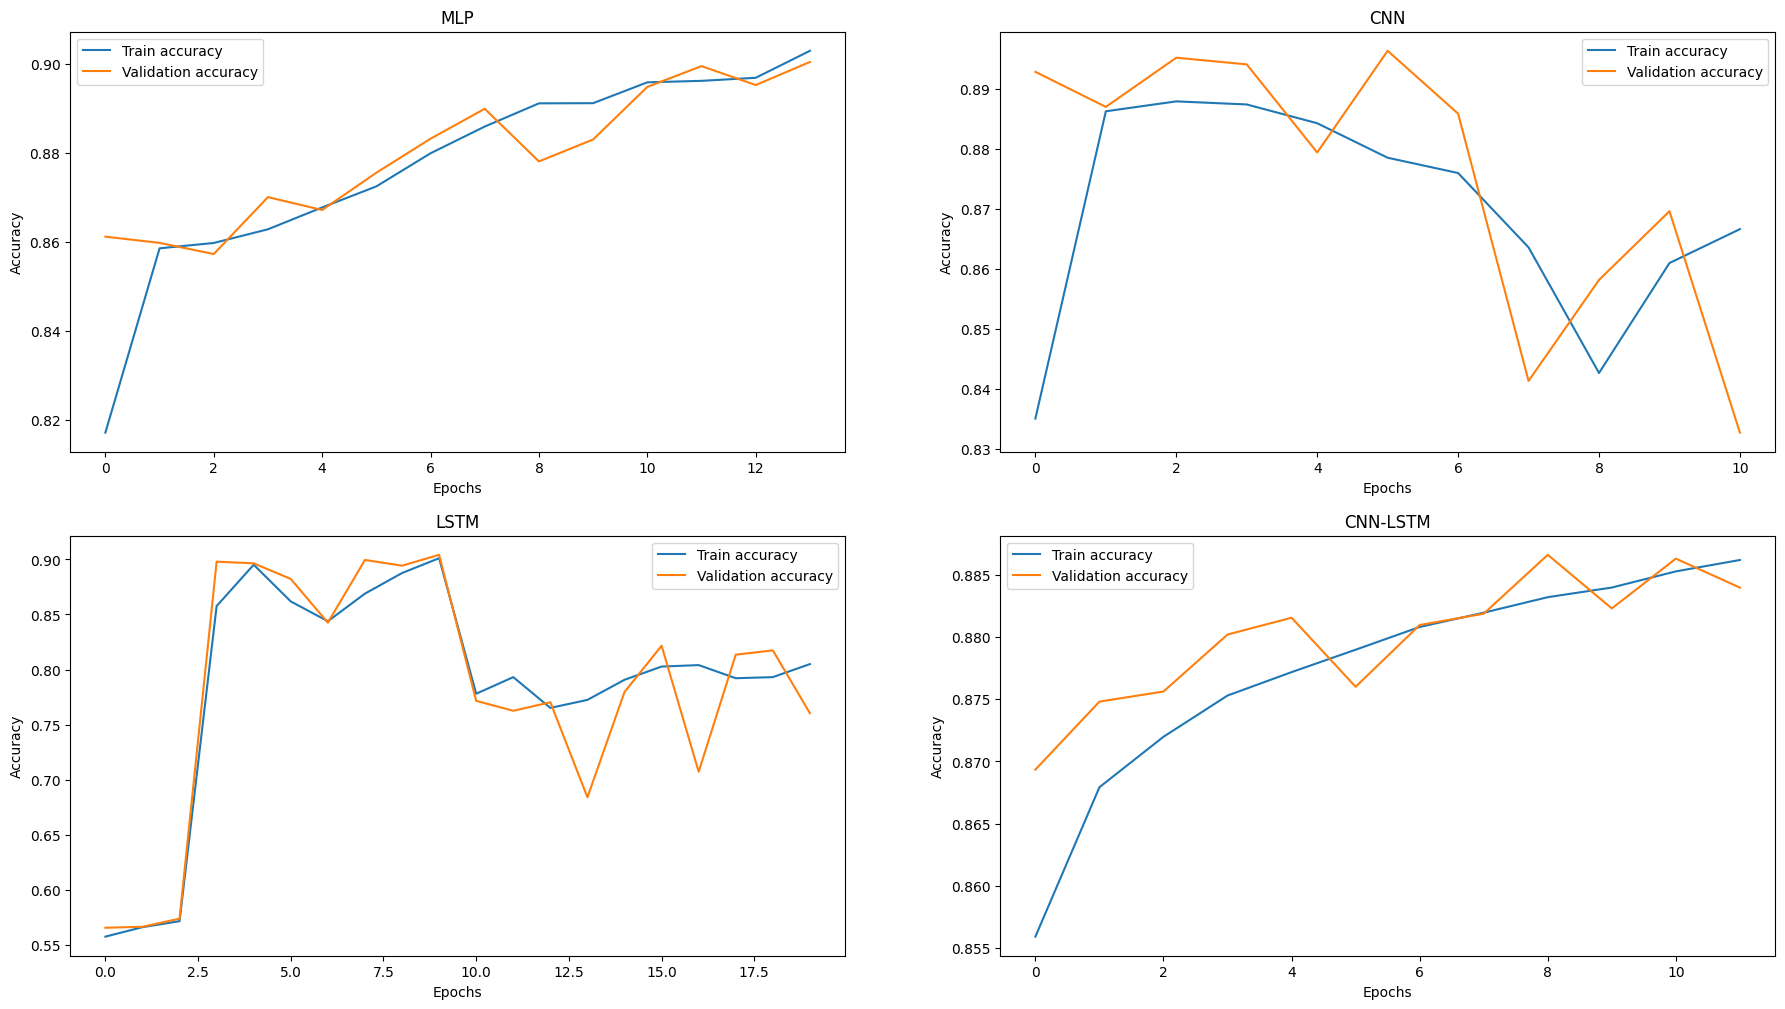

In [26]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['accuracy'], label='Train accuracy')
ax1.plot(mlp_history.history['val_accuracy'], label='Validation accuracy')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(cnn_history.history['accuracy'], label='Train accuracy')
ax2.plot(cnn_history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

ax3.plot(lstm_history.history['accuracy'], label='Train accuracy')
ax3.plot(lstm_history.history['val_accuracy'], label='Validation accuracy')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')

ax4.plot(cnn_lstm_history.history['accuracy'], label='Train accuracy')
ax4.plot(cnn_lstm_history.history['val_accuracy'], label='Validation accuracy')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')

plt.show()

#### MLP on train, validation and test

In [27]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train acc:', accuracy_score(np.argmax(Y_train, axis=1), np.argmax(mlp_train_pred, axis=1)))
print('Validation acc:', accuracy_score(np.argmax(Y_valid, axis=1), np.argmax(mlp_valid_pred, axis=1)))

8780/8780 [==============================] - 12s 1ms/step
Train acc: 0.8720650175001483
Validation acc: 0.8701014415376401


In [28]:
mlp_test_pred = model_mlp.predict(X_test.values)
print('Test acc:', accuracy_score(np.argmax(Y_test, axis=1), np.argmax(mlp_test_pred, axis=1)))

9407/9407 [==============================] - 13s 1ms/step
Test acc: 0.8673554474029533


#### CNN on train, validation and test

In [29]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train acc:', accuracy_score(np.argmax(Y_train, axis=1), np.argmax(cnn_train_pred, axis=1)))
print('Validation acc:', accuracy_score(np.argmax(Y_valid, axis=1), np.argmax(cnn_valid_pred, axis=1)))

8780/8780 [==============================] - 22s 2ms/step
Train acc: 0.8922560360681022
Validation acc: 0.8927816337426588


In [30]:
timesteps = window + 1
X_test_series = X_test.values.reshape((X_test.shape[0], timesteps, features))

cnn_test_pred = model_cnn.predict(X_test_series)
print('Test acc:', accuracy_score(np.argmax(Y_test, axis=1), np.argmax(cnn_test_pred, axis=1)))

9407/9407 [==============================] - 23s 2ms/step
Test acc: 0.9007291995415511


#### LSTM on train, validation and test

In [31]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train acc:', accuracy_score(np.argmax(Y_train, axis=1), np.argmax(lstm_train_pred, axis=1)))
print('Validation acc:', accuracy_score(np.argmax(Y_valid, axis=1), np.argmax(lstm_valid_pred, axis=1)))

8780/8780 [==============================] - 22s 3ms/step
Train acc: 0.9053141128314647
Validation acc: 0.8927816337426588


In [32]:
lstm_test_pred = model_lstm.predict(X_test_series)
print('Test acc:', accuracy_score(np.argmax(Y_test, axis=1), np.argmax(lstm_test_pred, axis=1)))

9407/9407 [==============================] - 59s 6ms/step
Test acc: 0.911429662973606


#### CNN-LSTM on train, validation and test

In [33]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train acc:', accuracy_score(np.argmax(Y_train, axis=1), np.argmax(cnn_lstm_train_pred, axis=1)))
print('Validation acc:', accuracy_score(np.argmax(Y_valid, axis=1), np.argmax(cnn_lstm_valid_pred, axis=1)))

8780/8780 [==============================] - 19s 2ms/step
Train acc: 0.8752280951533488
Validation acc: 0.8748140238476597


In [34]:
timesteps = X_test_series.shape[1]//subsequences
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, features))

cnn_lstm_test_pred = model_cnn_lstm.predict(X_test_series_sub)
print('Test acc:', accuracy_score(np.argmax(Y_test, axis=1), np.argmax(cnn_lstm_test_pred, axis=1)))

9407/9407 [==============================] - 20s 2ms/step
Test acc: 0.8713452817965882


In [35]:
def compute_accuracy(y_true, y_pred):    
    return accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    
def compute_f1_p_r(y_true, y_pred, average):
    return precision_recall_fscore_support(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average=average)

In [36]:
models = [
    (mlp_test_pred, 'NN \cite{taud2018multilayer}'), 
    (cnn_test_pred, 'CNN \cite{cnnstime}'), 
    (lstm_test_pred, 'LSTM \cite{hochreiter1997long}'), 
    (cnn_lstm_test_pred, 'CNN+LSTM \cite{karim2017lstm}')
]            
        
accuracies = [compute_accuracy(Y_test, m[0]) for m in models]
macros = [compute_f1_p_r(Y_test, m[0], 'macro') for m in models]
weighted = [compute_f1_p_r(Y_test, m[0], 'weighted') for m in models]

for m,a,ms,ws in zip(models,accuracies,macros,weighted):
    print('\\midrule')
    print('\\multirow{1}{*}{None} & ' 
          + m[1] + ' & ' 
          + "{:.1f}".format(round(a*100,1)) + '\\%  & '
          + "{:.1f}".format(round(ws[0]*100,1)) +'\\% & '
          + "{:.1f}".format(round(ms[0]*100,1)) +'\\% & '
          + "{:.1f}".format(round(ws[1]*100,1)) + '\\% & '
          + "{:.1f}".format(round(ms[1]*100,1)) + '\\%  & '
          + "{:.1f}".format(round(ws[2]*100,1)) + '\\% & '
          + "{:.1f}".format(round(ms[2]*100,1)) + '\\% \\\\')

\midrule
\multirow{1}{*}{None} & NN \cite{taud2018multilayer} & 86.7\%  & 86.7\% & 59.8\% & 86.7\% & 49.7\%  & 84.8\% & 49.6\% \\
\midrule
\multirow{1}{*}{None} & CNN \cite{cnnstime} & 90.1\%  & 89.1\% & 62.8\% & 90.1\% & 61.0\%  & 89.3\% & 61.5\% \\
\midrule
\multirow{1}{*}{None} & LSTM \cite{hochreiter1997long} & 91.1\%  & 89.9\% & 64.1\% & 91.1\% & 61.6\%  & 90.3\% & 62.6\% \\
\midrule
\multirow{1}{*}{None} & CNN+LSTM \cite{karim2017lstm} & 87.1\%  & 83.4\% & 48.0\% & 87.1\% & 50.1\%  & 85.2\% & 49.0\% \\


### Performance

#### Train Ours

In [37]:
train_embed = pd.read_csv('/workspace/PlayNet/handball_X_train.csv')
train_embed = reduce_mem_usage(train_embed)
embed = pd.read_csv('/workspace/PlayNet/embedding.csv', header=None)
embed = reduce_mem_usage(embed)

Memory usage of dataframe is 353.68 MB
Memory usage after optimization is: 88.42 MB
Decreased by 75.0%
Memory usage of dataframe is 160.76 MB
Memory usage after optimization is: 40.19 MB
Decreased by 75.0%


In [38]:
train_embed.describe()
embed.describe()

0              1              2              3   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min        -2.562500      -2.736328       1.864258      -1.998047   
25%         3.222656      -1.427734       4.589844       1.015625   
50%         4.855469       1.626953       6.250000       3.515625   
75%         5.570312       4.039062       7.273438       4.390625   
max        11.062500       9.429688      10.171875       6.832031   

                  4              5              6              7   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         0.427246      -0.059601       0.218384      -1.337891   
25%         6.375000       3.685547       3.908203       1.997070   
50%         7.187500       4.093750       4.171875       2.800781   
75%         8.320312       4.503906       4.460938       4.066406   
max        12.703125       8.640625       8.585938       9.835938   

                  8              9              10             11  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         1.212891      -3.464844      -3.554688      -0.694824   
25%         2.468750      -0.195068      -0.480225       1.776367   
50%         5.449219       0.184692       0.292236       3.625000   
75%         7.773438       1.455078       1.974609       4.988281   
max        11.039062       8.945312      10.078125       7.410156   

                  12             13             14             15  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         1.137695      -0.538086      -0.328857       1.019531   
25%         4.492188       3.105469       4.007812       4.898438   
50%         4.781250       4.664062       4.992188       5.132812   
75%         5.585938       5.910156       5.765625       5.593750   
max        10.367188       8.828125       8.976562       9.195312   

                  16             17             18             19  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         1.505859       0.610352       1.596680      -0.367188   
25%         5.738281       3.052734       6.347656       2.332031   
50%         6.382812       5.574219       7.550781       3.896484   
75%         6.808594       6.675781       7.847656       4.886719   
max        10.914062       8.929688      11.734375       8.226562   

                  20             21             22             23  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min         1.591797       0.820801       1.365234      -2.111328   
25%         4.980469       4.714844       4.648438       1.540039   
50%         5.554688       5.500000       5.562500       1.738281   
75%         6.335938       6.781250       5.957031       2.232422   
max         9.695312      10.539062       9.468750       6.394531   

                  24             25             26             27  \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean             NaN            NaN            NaN            NaN   
std         0.000000       0.000000       0.000000       0.000000   
min       

In [39]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_embed, embed.values, test_size=0.1, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (632143, 66)
Validation set shape (70239, 66)


In [40]:
model_emb = Sequential()
model_emb.add(Dense(500, activation='relu', input_dim=X_train.shape[1]))
model_emb.add(Dense(500, activation='relu'))
model_emb.add(Dense(2000, activation='relu'))
model_emb.add(Dense(30))
model_emb.compile(loss='mean_squared_error', optimizer=rms)
model_emb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 500)               33500     
                                                                 
 dense_12 (Dense)            (None, 500)               250500    
                                                                 
 dense_13 (Dense)            (None, 2000)              1002000   
                                                                 
 dense_14 (Dense)            (None, 30)                60030     
                                                                 
Total params: 1,346,030
Trainable params: 1,346,030
Non-trainable params: 0
_________________________________________________________________


In [41]:
embed_history = model_emb.fit(
    X_train.values, Y_train, 
    validation_data=(X_valid.values, Y_valid), 
    epochs=epochs, verbose=2, callbacks=callback
)

Epoch 1/40
19755/19755 - 88s - loss: 0.5114 - val_loss: 0.3987 - 88s/epoch - 4ms/step
Epoch 2/40
19755/19755 - 82s - loss: 0.3773 - val_loss: 0.3671 - 82s/epoch - 4ms/step
Epoch 3/40
19755/19755 - 80s - loss: 0.3500 - val_loss: 0.3465 - 80s/epoch - 4ms/step
Epoch 4/40
19755/19755 - 80s - loss: 0.3315 - val_loss: 0.3392 - 80s/epoch - 4ms/step
Epoch 5/40
19755/19755 - 80s - loss: 0.3162 - val_loss: 0.3153 - 80s/epoch - 4ms/step
Epoch 6/40
19755/19755 - 83s - loss: 0.3033 - val_loss: 0.3109 - 83s/epoch - 4ms/step
Epoch 7/40
19755/19755 - 84s - loss: 0.2917 - val_loss: 0.2972 - 84s/epoch - 4ms/step
Epoch 8/40
19755/19755 - 85s - loss: 0.2816 - val_loss: 0.2913 - 85s/epoch - 4ms/step
Epoch 9/40
19755/19755 - 86s - loss: 0.2731 - val_loss: 0.2956 - 86s/epoch - 4ms/step
Epoch 10/40
19755/19755 - 85s - loss: 0.2657 - val_loss: 0.2802 - 85s/epoch - 4ms/step
Epoch 11/40
19755/19755 - 84s - loss: 0.2591 - val_loss: 0.2877 - 84s/epoch - 4ms/step
Epoch 12/40
19755/19755 - 85s - loss: 0.2536 - val_l

#### Test Ours

In [42]:
test_embed = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')
test_embed = reduce_mem_usage(test_embed)

ours_start = perf_counter()

for index, row in test_embed.iterrows():
    res = model_emb(np.array([row.values,]), training=False).numpy()

ours_stop = perf_counter()

Memory usage of dataframe is 151.58 MB
Memory usage after optimization is: 37.89 MB
Decreased by 75.0%


In [43]:
print("Elapsed time:", ours_stop, ours_start)
print("Tested ", test_embed.shape[0], " elements") 
print("Elapsed time in seconds:", ours_stop-ours_start)
print("Perf average per element: ", (ours_stop-ours_start)*1000/test_embed.shape[0], " ms")

Elapsed time: 8873561.334543707 8872987.154230751
Tested  301022  elements
Elapsed time in seconds: 574.180312955752
Perf average per element:  1.9074363765962354  ms


#### Test MLP

In [44]:
# TODO Check counts, not same
mlp_start = perf_counter()

for index, row in X_test.iterrows():
    res = model_mlp(np.array([row.values,]), training=False).numpy()

mlp_stop = perf_counter()

In [45]:
print("Elapsed time:", mlp_stop, mlp_start)
print("Tested ", X_test.shape[0], " elements") 
print("Elapsed time in seconds:", mlp_stop-mlp_start)
print("Perf average per element: ", (mlp_stop-mlp_start)*1000/X_test.shape[0], " ms")

Elapsed time: 8874132.117533093 8873561.349605149
Tested  301015  elements
Elapsed time in seconds: 570.7679279446602
Perf average per element:  1.8961444710219097  ms


#### Test CNN

In [46]:
timesteps = window + 1
X_test_series = X_test.values.reshape((X_test.shape[0], timesteps, features))

cnn_start = perf_counter()

for row in X_test_series:
    res = model_cnn(np.array([row,]), training=False).numpy()

cnn_stop = perf_counter()

In [47]:
print("Elapsed time:", cnn_stop, cnn_start)
print("Tested ", X_test_series.shape[0], " elements") 
print("Elapsed time in seconds:", cnn_stop-cnn_start)
print("Perf average per element: ", (cnn_stop-cnn_start)*1000/X_test_series.shape[0], " ms")

Elapsed time: 8876076.940771403 8874132.132302504
Tested  301015  elements
Elapsed time in seconds: 1944.8084688987583
Perf average per element:  6.460835735424342  ms


#### Test LSTM

In [48]:
lstm_start = perf_counter()

for row in X_test_series:
    res = model_lstm(np.array([row,]), training=False).numpy()

lstm_stop = perf_counter()

In [49]:
print("Elapsed time:", lstm_stop, lstm_start)
print("Tested ", X_test.shape[0], " elements") 
print("Elapsed time in seconds:", lstm_stop-lstm_start)
print("Perf average per element: ", (lstm_stop-lstm_start)*1000/X_test_series.shape[0], " ms")

Elapsed time: 8883667.111463228 8876076.959023846
Tested  301015  elements
Elapsed time in seconds: 7590.152439381927
Perf average per element:  25.215196715718243  ms


#### Test CNN+LSTM

In [50]:
timesteps = X_test_series.shape[1]//subsequences
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, features))

cnn_lstm_start = perf_counter()

for row in X_test_series_sub:
    res = model_cnn_lstm(np.array([row,]), training=False).numpy()

cnn_lstm_stop = perf_counter()

In [51]:
print("Elapsed time:", cnn_lstm_stop, cnn_lstm_start)
print("Tested ", X_test.shape[0], " elements") 
print("Elapsed time in seconds:", cnn_lstm_stop-cnn_lstm_start)
print("Perf average per element: ", (cnn_lstm_stop-cnn_lstm_start)*1000/X_test_series_sub.shape[0], " ms")

Elapsed time: 8887044.953933608 8883667.127574885
Tested  301015  elements
Elapsed time in seconds: 3377.826358722523
Perf average per element:  11.221455272071235  ms


#### GFLOPs

In [52]:
forward_pass_ours = tf.function(
    model_emb.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model_emb.input_shape[1:])])

profiler_ours = Profiler(graph=forward_pass_ours.get_concrete_function().graph)
pro_ours=profiler_ours.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops_ours = pro_ours.total_float_ops // 2
print('Flops Ours: {:,}'.format(flops_ours))

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Flops Ours: 1,344,515
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The

In [53]:
forward_pass_mlp = tf.function(
    model_mlp.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model_mlp.input_shape[1:])])

profiler_mlp = Profiler(graph=forward_pass_mlp.get_concrete_function().graph)
pro_mlp=profiler_mlp.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops_mlp = pro_mlp.total_float_ops // 2
print('Flops mlp: {:,}'.format(flops_mlp))

Flops mlp: 1,529,503
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the ma

In [54]:
forward_pass_cnn = tf.function(
    model_cnn.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model_cnn.input_shape[1:])])

profiler_cnn = Profiler(graph=forward_pass_cnn.get_concrete_function().graph)
pro_cnn=profiler_cnn.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops_cnn = pro_cnn.total_float_ops // 2
print('Flops cnn: {:,}'.format(flops_cnn))

Flops cnn: 6,080,197
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the ma

In [55]:
forward_pass_lstm = tf.function(
    model_lstm.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model_lstm.input_shape[1:])])

profiler_lstm = Profiler(graph=forward_pass_lstm.get_concrete_function().graph)
pro_lstm=profiler_lstm.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops_lstm = pro_lstm.total_float_ops // 2
print('Flops lstm: {:,}'.format(flops_lstm))

Flops lstm: 1,384,853
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the m

In [56]:
forward_pass_cnn_lstm = tf.function(
    model_cnn_lstm.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model_cnn_lstm.input_shape[1:])])

profiler_cnn_lstm = Profiler(graph=forward_pass_cnn_lstm.get_concrete_function().graph)
pro_cnn_lstm=profiler_cnn_lstm.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops_cnn_lstm = pro_cnn_lstm.total_float_ops // 2
print('Flops cnn_lstm: {:,}'.format(flops_cnn_lstm))

Flops cnn_lstm: 1,386,778
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for t

5 ops no flops stats due to incomplete shapes.
Incomplete shape.
Incomplete shape.


#### LaTeX

In [69]:
avg_ours = (ours_stop-ours_start) * 1000 / test_embed.shape[0]
norm = 17.74 / avg_ours
avg_mlp = (mlp_stop-mlp_start) * 1000 / X_test.shape[0]
norm_mlp = avg_mlp * norm
avg_cnn = (cnn_stop-cnn_start) * 1000 / X_test_series.shape[0]
norm_cnn = avg_cnn * norm
avg_lstm = (lstm_stop-lstm_start) * 1000 / X_test_series.shape[0]
norm_lstm = avg_lstm * norm
avg_lstm_cnn = (cnn_lstm_stop-cnn_lstm_start) * 1000 / X_test_series_sub.shape[0]
norm_lstm_cnn = avg_lstm_cnn * norm

gflops_ours = flops_ours/(17.74/1000)/1e9
gflops_mlp = flops_mlp/(norm_mlp/1000)/1e9
gflops_cnn = flops_cnn/(norm_cnn/1000)/1e9
gflops_lstm = flops_lstm/(norm_lstm/1000)/1e9
gflops_lstm_cnn = flops_cnn_lstm/(norm_lstm_cnn/1000)/1e9

print("Ours (Emb. + KNN) & ", 
      "{:.2f}M".format(round(model_emb.count_params()/1.0e6,2)), 
      " & {:.3f}".format(round(gflops_ours,3)),
      " & ",
      "{:.2f}".format(round(17.74,2)),
      " \\\\")
print("NN \cite{taud2018multilayer} & ", 
      "{:.2f}M".format(round(model_mlp.count_params()/1.0e6,2)), 
      " & {:.3f}".format(round(gflops_mlp,3)),
      " & ",
      "{:.2f}".format(round(norm_mlp,2)),
      " \\\\")

print("CNN \cite{cnnstime} & ", 
      "{:.2f}M".format(round(model_cnn.count_params()/1.0e6,2)), 
      " & {:.3f}".format(round(gflops_cnn,3)),
      " & ",
      "{:.2f}".format(round(norm_cnn,2)),
      " \\\\")
print("LSTM \cite{hochreiter1997long} & ", 
      "{:.2f}M".format(round(model_lstm.count_params()/1.0e6,2)), 
      " & {:.3f}".format(round(gflops_lstm,3)),
      " & ",
      "{:.2f}".format(round(norm_lstm,2)),
      " \\\\")
print("CNN+LSTM \cite{karim2017lstm} & ", 
      "{:.2f}M".format(round(model_cnn_lstm.count_params()/1.0e6,2)), 
      " & {:.3f}".format(round(gflops_lstm_cnn,3)),
      " & ",
      "{:.2f}".format(round(norm_lstm_cnn,2)),
      " \\\\")

Ours (Emb. + KNN) &  1.35M  & 0.076  &  17.74  \\
NN \cite{taud2018multilayer} &  1.53M  & 0.082  &  18.60  \\
CNN \cite{cnnstime} &  1.44M  & 0.101  &  60.09  \\
LSTM \cite{hochreiter1997long} &  1.39M  & 0.006  &  234.51  \\
CNN+LSTM \cite{karim2017lstm} &  1.47M  & 0.013  &  104.36  \\
